In [1]:
using Revise
using QuantumGraining
using QuantumCumulants
using Symbolics
using OrdinaryDiffEq
using ModelingToolkit
using Plots

# Time-coarse grained Rabi model

To demonstrate the use of the method, we start with a simple but illustrative example -- the Rabi model. The Rabi model describes the interaction of a single field mode interacting with a two-level system. However, unlike the Jaynes-Cummings model, it does not assume the rotating-wave approximation (RWA). More concretely, the model is described by the following Hamiltonian terms in the interaction picture,

$$
    \begin{align*}
    &g_{\Omega}
    =
    \{\frac{g}{2}, \frac{g}{2}, \frac{g}{2}, \frac{g}{2}\} \\
    &h_{\Omega}
    =
    \{\hat{a}\hat{\sigma}_-, \hat{a}^\dagger \hat{\sigma}_+, \hat{a}\hat{\sigma}_+, \hat{a}^\dagger \hat{\sigma_-} \} \\
    &\Omega
    =
    \{
    - \big( \omega_c + \omega_a \big),
    \omega_c + \omega_a,
    - \omega_c + \omega_a,
    \omega_c - \omega_a
    \} \\
    &\hat{H} = \sum_{\omega \in \Omega} g_\omega h_\omega e^{-i\omega t}
\end{align*}
$$

We start by coding in the Hamiltonian. We use `QuantumCumulants` to handle the operator algebra, a `Symbolics` for handling the symbolic calculations.

In [2]:
@variables g ωc ωa
Ω = [-ωc - ωa, ωc + ωa, -ωc + ωa, ωc - ωa]
gvec = (g/2).*[1, 1, 1, 1]

# Hilbert space definitions
h_cav = FockSpace(:cavity)
h_atom = NLevelSpace(:atom, (:g,:e))
h = tensor(h_cav, h_atom)

# Operator definitions
@qnumbers a::Destroy(h) σ::Transition(h)
σm = σ(:e, :g)
σp = σ(:g, :e)
hvec = [a*σm, a'*σp, a*σp, a'*σm]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 (a*σeg)
 (a′*σge)
 (a*σge)
 (a′*σeg)

## First-order time-coarse graining - the JC model

To first-order the corrections are only Hermitian, and depend on a single contraction coefficient.

$$
    C_{1,0}(\omega) = e^{- \frac{\omega^2 \tau^2}{2}}
$$

We can calculate the first-order by hand, and compare it to the results obtained by `QuantumGraining.jl`. For brevity, let us denote,
$$
    \overline{\omega} = \omega_c + \omega_a \rightarrow \hat{a}^\dagger \hat{\sigma}_+ \\
    \Delta = \omega_c - \omega_a \rightarrow \hat{a}^\dagger \sigma_-
$$

Collecting the relevant corrections,
$$
    \overline{\omega}: \ \ \ g_{a^\dagger \sigma_+} = \frac{g}{2} e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0 \\
    \Delta: \ \ \ g_{a^\dagger \sigma_-} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2} \\
    -\Delta: \ \ \ g_{a \sigma_+} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2}\\
    -\overline{\omega}: \ \ \ g_{a \sigma_-} = e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0
$$
which approximately gives the RWA Hamiltonian (it would be given directly for a cutoff filter).
$$
    H^{(1)} = \frac{g}{2} \left ( \hat{a}^\dagger \hat{\sigma}_- e^{i\Delta t} + \hat{a}\sigma_+ e^{-i\Delta t}\right )
$$



Equivalently, let us also do that by calling the `effective_hamiltonian_term` function, which calculates a single order of the TCG Hamiltonian.

In [3]:
ops_eff_1, g_eff_1, Ω_eff_1 = effective_hamiltonian_term(hvec, gvec, Ω, 1)

# We can also call `effective_hamiltonian`, which gives the full Hamiltonian to a given order.
# To first order these are the same.
ops_eff_1, g_eff_1, Ω_eff_1 = effective_hamiltonian(hvec, gvec, Ω, 1)

(Any[(a*σeg), (a′*σge), (a*σge), (a′*σeg)], Any[g*exp(-0.5(τ^2)*((-ωa - ωc)^2)), g*exp(-0.5(τ^2)*((ωa + ωc)^2)), g*exp(-0.5(τ^2)*((ωa - ωc)^2)), g*exp(-0.5(τ^2)*((ωc - ωa)^2))], Any[-ωa - ωc, ωa + ωc, ωa - ωc, ωc - ωa])

In [4]:
ops_eff_1

4-element Vector{Any}:
 (a*σeg)
 (a′*σge)
 (a*σge)
 (a′*σeg)

In [5]:
g_eff_1

4-element Vector{Any}:
 g*exp(-0.5(τ^2)*((-ωa - ωc)^2))
 g*exp(-0.5(τ^2)*((ωa + ωc)^2))
 g*exp(-0.5(τ^2)*((ωa - ωc)^2))
 g*exp(-0.5(τ^2)*((ωc - ωa)^2))

To visualize the result, it is useful to use the `symbolic_hamiltonian` function, which renders the Hamiltonian in Latex.

In [7]:
@variables t τ  # define symbolic variables for displaying
H_1 = sum(symbolic_hamiltonian(g_eff_1, ops_eff_1, Ω_eff_1, t, τ));

H_1

g*exp(-0.5(τ^2)*((-ωa - ωc)^2))*exp(im*t*(ωa + ωc))
g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2))
g*exp(im*t*(ωc - ωa))*exp(-0.5(τ^2)*((ωa - ωc)^2))
g*exp(-0.5(τ^2)*((ωc - ωa)^2))*exp(im*t*(ωa - ωc))


(g*exp(-0.5(τ^2)*((-ωa - ωc)^2))*exp(im*t*(ωa + ωc))*(a*σeg)+g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2))*(a′*σge)+g*exp(im*t*(ωc - ωa))*exp(-0.5(τ^2)*((ωa - ωc)^2))*(a*σge)+g*exp(-0.5(τ^2)*((ωc - ωa)^2))*exp(im*t*(ωa - ωc))*(a′*σeg))

The results are a little bit hard to read, since they include also high-frequency terms weighted by the Gaussian filter. We can simplify the comparison to the RWA by replacing the Gaussian filter by a cutoff filter.

Since $\omega_c$ and $\omega_a$ are just symbols, we need to give them a value to decide whether an expression is high-frequency or not.

In [8]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)

Dict{Num, Real} with 2 entries:
  ωa => 1
  ωc => 1.01

With that, we can drop the high-frquency terms using `drop_high_freqs`. We can also call the function `gaussian_to_cutoff` to remove completely any high-frequency terms.

In [13]:
rwa, Ω_rwa_1 = drop_high_freqs(Ω_eff_1, freqs_subs)
g_rwa_1 = gaussian_to_cutoff(g_eff_1[rwa], freqs_subs)
ops_rwa_1 = ops_eff_1[rwa]

2-element Vector{Any}:
 (a*σge)
 (a′*σeg)

In [14]:
g_rwa_1

2-element Vector{ContractionCoefficient}:
 g
 g

In [15]:
Ω_rwa_1

2-element Vector{Any}:
 ωa - ωc
 ωc - ωa

In [16]:
H_rwa_1 = sum(symbolic_hamiltonian(g_rwa_1, ops_rwa_1, Ω_rwa_1, t, τ))

g*exp(im*t*(ωc - ωa))
g*exp(im*t*(ωa - ωc))


(g*exp(im*t*(ωc - ωa))*(a*σge)+g*exp(im*t*(ωa - ωc))*(a′*σeg))

which is exactly the RWA Hamiltonian.

## Second-order time-coarse graining

To second-order, this we have two contraction coefficients.
$$
    C_{2,0}(\omega, \omega') = -C_{1,1}(\omega, \omega') = f(\omega, \omega') \\
    f(\omega, \omega') = \frac{1}{\omega'} \left [ e^{-\frac{\omega^2 + \omega'^2}{2}\tau^2} - e^{-\frac{(\omega + \omega')^2\tau^2}{2}} \right ]
$$

where we also have the following symmetries,
$$
    f(\omega, \omega') = \frac{\omega}{\omega'} f(\omega', \omega) \\
    f(\omega, -\omega') = -f(\omega, \omega')
$$

### Hamiltonian contributions

In [17]:
ops_eff_2, g_eff_2, Ω_eff_2 = effective_hamiltonian_term(hvec, gvec, Ω, 2)

(Any[0, (-1*(a′*a*σee)+(a′*a)), (-1*(a*a*σee)+(a*a)), 0, (σee+(a′*a*σee)), 0, 0, (a′*a′*σee), (a*a*σee), 0, 0, (a′*a*σee), 0, (-1*(a′*a′*σee)+(a′*a′)), (-1*(σee)+1+-1*(a′*a*σee)+(a′*a)), 0], ContractionCoefficient[0, (1//8)*(g^2)*(-1 / (-ωa - ωc)) + (1//8)*(g^2)*(1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)), (-ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / (4(ωc - ωa)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωc - ωa) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωc^2)), (-ωc*(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (-ωa - ωc)^2))) / (4(ωa - ωc)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωa - ωc) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωa^2)), (1//8)*(g^2)*(-1 / (ωa + ωc)) + (1//8)*(g^2)*(1 / (ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)), 0, (ωc*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / (4(ωa + ωc)*(ωc - ωa)) + (1//16)*(g^2)*(-1 / (ωa + ωc) + -1 / (ωc - ωa))*exp(-2.0(τ^2)*(ωa^2)), (ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / (4(ωa + ωc)*(ωa - ωc)) + (1//16)*(g^2)*(-1 / (

Most terms vanish simply due to the operators falling outside of the two-level manifold, i.e. $\hat{\sigma}_{\pm} \hat{\sigma}_{\pm} = 0$. The surviving terms would correspond to the following frequnecy pairs $\{ (\overline{\omega}, \Delta), (\overline{\omega}, -\overline{\omega}), (\Delta, -\Delta), (-\overline{\omega}, -\Delta) \}$, as well as their conjugates.

In [18]:
ops_eff_2

16-element Vector{Any}:
 0
  (-1*(a′*a*σee)+(a′*a))
  (-1*(a*a*σee)+(a*a))
 0
  (σee+(a′*a*σee))
 0
 0
  (a′*a′*σee)
  (a*a*σee)
 0
 0
  (a′*a*σee)
 0
  (-1*(a′*a′*σee)+(a′*a′))
  (-1*(σee)+1+-1*(a′*a*σee)+(a′*a))
 0

* TODO: `effective_hamiltonian` should return just unique terms, and sum the contributions to the couplings appropriately.

The coupling strengths are related to the contraction coefficients by the following symmetries,
$$
    g(\omega, -\omega) = f(\omega, -\omega) + f(\omega, -\omega) = 2f(\omega, -\omega) \\
    g(-\omega, \omega) = f(-\omega, \omega) + f(-\omega, \omega) = -2f(\omega, -\omega) \\
    g(\omega, -\omega) = -g(-\omega, \omega)
$$

The coupling strengths are calculated directly from the contraction coefficients and are given by,
$$
    g_{\overline{\omega}, \Delta} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\

    g_{\overline{\omega}, -\overline{\omega}} = \frac{2}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \approx - \frac{2}{\overline{\omega}} \\

    g_{\Delta, -\Delta} = \frac{2}{\Delta} \left [ e^{-\Delta^2 \tau^2} - 1\right ] \approx -2\tau^2 \Delta \\

    g_{\Delta, -\overline{\omega}} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\
$$

We can again compare with the coefficients obtained using `QuantumGraining.jl`. We first look at the frequencies of the different terms, as well as the different coupling corresponding to them.

In [19]:
Ω_eff_2 .=> g_eff_2

16-element Vector{Pair{Num, ContractionCoefficient}}:
 -2ωa - 2ωc => 0
          0 => (1//8)*(g^2)*(-1 / (-ωa - ωc)) + (1//8)*(g^2)*(1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))
       -2ωc => (-ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / (4(ωc - ωa)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωc - ωa) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωc^2))
       -2ωa => (-ωc*(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (-ωa - ωc)^2))) / (4(ωa - ωc)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωa - ωc) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωa^2))
          0 => (1//8)*(g^2)*(-1 / (ωa + ωc)) + (1//8)*(g^2)*(1 / (ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))
  2ωa + 2ωc => 0
        2ωa => (ωc*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / (4(ωa + ωc)*(ωc - ωa)) + (1//16)*(g^2)*(-1 / (ωa + ωc) + -1 / (ωc - ωa))*exp(-2.0(τ^2)*(ωa^2))
        2ωc => (ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / (4(ωa + ωc)*(ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωa + ωc) + -1 / (ωa - ωc))*exp(-2.0(τ^2)*(ωc^2)

In [20]:
to_symbol.(g_eff_2, τ)

16-element Vector{Num}:
                                                               0
 (1//8)*(g^2)*(-1 / (-ωa - ωc)) + (1//8)*(g^2)*(1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))
                                                     (-ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / (4(ωc - ωa)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωc - ωa) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωc^2))
                                                     (-ωc*(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (-ωa - ωc)^2))) / (4(ωa - ωc)*(-ωa - ωc)) + (1//16)*(g^2)*(-1 / (ωa - ωc) + -1 / (-ωa - ωc))*exp(-2.0(τ^2)*(ωa^2))
   (1//8)*(g^2)*(-1 / (ωa + ωc)) + (1//8)*(g^2)*(1 / (ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))
                                                               0
                                                      (ωc*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / (4(ωa + ωc)*(ωc - ωa)) + (1//16)*(g^2)*(-1 / (ωa + ωc) + -1 / (ωc - ωa))*exp(-2.0(τ^2)*(ωa^2))
         

Again, the full expression is very busy and hard to dechiper. As before, let us simplify the weights and drop high-frequency terms.

In [21]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
rwa, Ω_rwa_2 = drop_high_freqs(Ω_eff_2, freqs_subs)

(Any[2, 5, 11, 12, 15, 16], Any[0, 0, 2ωa - 2ωc, 0, 0, 2ωc - 2ωa])

In [22]:
ops_rwa_2 = ops_eff_2[rwa]
Ω_rwa_2 .=> ops_rwa_2

6-element Vector{Pair{Num}}:
         0 => (-1*(a′*a*σee)+(a′*a))
         0 => (σee+(a′*a*σee))
 2ωa - 2ωc => 0
         0 => (a′*a*σee)
         0 => (-1*(σee)+1+-1*(a′*a*σee)+(a′*a))
 2ωc - 2ωa => 0

To simplify the expressions further, we remove the exponentially suppressed terms.

In [23]:
g_rwa_2 = gaussian_to_cutoff(g_eff_2[rwa], freqs_subs, keep_small_exponents=true)
g_rwa_2 .=> ops_rwa_2

6-element Vector{Pair{ContractionCoefficient}}:
                                                                          (1//8)*(g^2)*(-1 / (-ωa - ωc)) => (-1*(a′*a*σee)+(a′*a))
                                                                           (1//8)*(g^2)*(-1 / (ωa + ωc)) => (σee+(a′*a*σee))
                                                                                                       0 => 0
 (1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)) => (a′*a*σee)
 (1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)) => (-1*(σee)+1+-1*(a′*a*σee)+(a′*a))
                                                                                                       0 => 0

In [24]:
to_symbol.(g_rwa_2, τ)

6-element Vector{Num}:
                                (1//8)*(g^2)*(-1 / (-ωa - ωc))
                                 (1//8)*(g^2)*(-1 / (ωa + ωc))
                                                             0
 (1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))
 (1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))
                                                             0

We find that the second order contribution is,

$$
    \hat{H}^{(2)} = (g_1 - g_2)\hat{a}^\dagger \hat{a} - (g_1 - g_2)\hat{\sigma}_z - 2(g_1 - g_2) \hat{a}^\dagger \hat{a} \hat{\sigma}_z
$$
where,
$$
    g_1 = \frac{g^2}{8\overline{\omega}} \\
    g_2 = \frac{g^2}{8\Delta}\cdot \left ( 1 - \exp(-\Delta^2 τ^2) \right ) \approx \frac{g^2}{8\Delta}\cdot \Delta^2\tau^2 = \frac{g^2\tau^2}{8}\cdot \Delta \\
    g_1 - g_2 = \frac{g^2}{8} \left ( \frac{1}{\overline{\omega}} -  \tau^2 \Delta \right )
$$

Thus we see that the second-order contribution changes the resonant frequencies of the qubit and the resonator, while also inducing an apparent longitudinal coupling between them.

We can do that automatically using the function `symbolic_hamiltonian`,

In [26]:
H_rwa_2 = sum(symbolic_hamiltonian(g_rwa_2, ops_rwa_2, Ω_rwa_2, t, τ))

(1//8)*(g^2)*(-1 / (-ωa - ωc))
(1//8)*(g^2)*(-1 / (ωa + ωc))
0
(1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))
(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))
0


((-1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(σee)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a))

### The TCG Dissipators

In addition, in second order we also have dissipators generated by the method.

In [27]:
γ_eff_2, ω_eff_2, J_eff_2 = effective_dissipator_term(hvec.*gvec, Ω, 2)

(Any[im*((-exp(-(τ^2)*((ωa + ωc)^2))) / (ωa + ωc) + (-exp(-2.0(τ^2)*((-ωa - ωc)^2))) / (-ωa - ωc) + exp(-2.0(τ^2)*((ωa + ωc)^2)) / (ωa + ωc) + exp(-(τ^2)*((-ωa - ωc)^2)) / (-ωa - ωc)), im*((-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2)) + (-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))), im*((-exp(-0.5((ωa - ωc)^2 + (-ωa - ωc)^2 + 2(ωa - ωc)*(-ωa - ωc))*(τ^2))) / (-ωa - ωc) + (-exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / (ωc - ωa) + exp(-0.5((ωa + ωc)^2 + (ωc - ωa)^2 + 2(ωa + ωc)*(ωc - ωa))*(τ^2)) / (ωc - ωa) + exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2)) / (-ωa - ωc)), im*((-exp(-0.5((ωc - ωa)^2 + (-ωa - ωc)^2 + 2(ωc - ωa)*(-ωa - ωc))*(τ^2))) / (-ωa - ωc) + (-exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / (ωa - ωc) + exp(-0.5((ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc))*(τ^2)) / (ωa - ωc) + exp(-0.5(τ^2)*((ωc - ωa)^2 + (-ωa - ωc)^2)) / (-ωa - ωc)), im*((-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5((

In [28]:
ω_eff_2 .=> J_eff_2

16-element Vector{Pair{Num, Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}}}:
 -2ωa - 2ωc => ((1//2)*g*(a*σeg), (1//2)*g*(a*σeg))
          0 => ((1//2)*g*(a′*σge), (1//2)*g*(a*σeg))
       -2ωc => ((1//2)*g*(a*σge), (1//2)*g*(a*σeg))
       -2ωa => ((1//2)*g*(a′*σeg), (1//2)*g*(a*σeg))
          0 => ((1//2)*g*(a*σeg), (1//2)*g*(a′*σge))
  2ωa + 2ωc => ((1//2)*g*(a′*σge), (1//2)*g*(a′*σge))
        2ωa => ((1//2)*g*(a*σge), (1//2)*g*(a′*σge))
        2ωc => ((1//2)*g*(a′*σeg), (1//2)*g*(a′*σge))
       -2ωc => ((1//2)*g*(a*σeg), (1//2)*g*(a*σge))
        2ωa => ((1//2)*g*(a′*σge), (1//2)*g*(a*σge))
  2ωa - 2ωc => ((1//2)*g*(a*σge), (1//2)*g*(a*σge))
          0 => ((1//2)*g*(a′*σeg), (1//2)*g*(a*σge))
       -2ωa => ((1//2)*g*(a*σeg), (1//2)*g*(a′*σeg))
        2ωc => ((1//2)*g*(a′*σge), (1//2)*g*(a′*σeg))
          0 => ((1//2)*g*(a*σge), (1//2)*g*(a′*σeg))
  2ωc - 2ωa => ((1//2)*g*(a′*σeg), (1//2)*g*(a′*σeg))

Again, to simplify we drop high-frequency terms,

In [29]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
rwa, ω_rwa_2 = drop_high_freqs(ω_eff_2, freqs_subs)

(Any[2, 5, 11, 12, 15, 16], Any[0, 0, 2ωa - 2ωc, 0, 0, 2ωc - 2ωa])

In [30]:
γ_rwa_2 = γ_eff_2[rwa]

6-element Vector{Any}:
 im*((-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2)) + (-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)))
 im*((-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2)) + (-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)))
 im*((-exp(-(τ^2)*((ωc - ωa)^2))) / (ωc - ωa) + (-exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + exp(-(τ^2)*((ωa - ωc)^2)) / (ωa - ωc) + exp(-2.0(τ^2)*((ωc - ωa)^2)) / (ωc - ωa))
 im*((1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
 im*((-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
 im*((-exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (-exp(-2.0(

In [31]:
J_rwa_2 = J_eff_2[rwa]

6-element Vector{Any}:
 ((1//2)*g*(a′*σge), (1//2)*g*(a*σeg))
 ((1//2)*g*(a*σeg), (1//2)*g*(a′*σge))
 ((1//2)*g*(a*σge), (1//2)*g*(a*σge))
 ((1//2)*g*(a′*σeg), (1//2)*g*(a*σge))
 ((1//2)*g*(a*σge), (1//2)*g*(a′*σeg))
 ((1//2)*g*(a′*σeg), (1//2)*g*(a′*σeg))

In [32]:
ω_rwa_2 .=> J_rwa_2

6-element Vector{Pair{Num, Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}}}:
         0 => ((1//2)*g*(a′*σge), (1//2)*g*(a*σeg))
         0 => ((1//2)*g*(a*σeg), (1//2)*g*(a′*σge))
 2ωa - 2ωc => ((1//2)*g*(a*σge), (1//2)*g*(a*σge))
         0 => ((1//2)*g*(a′*σeg), (1//2)*g*(a*σge))
         0 => ((1//2)*g*(a*σge), (1//2)*g*(a′*σeg))
 2ωc - 2ωa => ((1//2)*g*(a′*σeg), (1//2)*g*(a′*σeg))

In [33]:
ω_rwa_2 .=> γ_rwa_2

6-element Vector{Pair{Num, ContractionCoefficient}}:
         0 => im*((-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2)) + (-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)))
         0 => im*((-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2)) + (-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2)))
 2ωa - 2ωc => im*((-exp(-(τ^2)*((ωc - ωa)^2))) / (ωc - ωa) + (-exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + exp(-(τ^2)*((ωa - ωc)^2)) / (ωa - ωc) + exp(-2.0(τ^2)*((ωc - ωa)^2)) / (ωc - ωa))
         0 => im*((1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
         0 => im*((-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5

In [34]:
γ_rwa_2 = gaussian_to_cutoff(γ_eff_2[rwa], freqs_subs, keep_small_exponents=true)

6-element Vector{ContractionCoefficient}:
 im*(-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2))
 im*(-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2))
 im*((4.0exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (-4.0exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc))
 im*((1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
 im*((-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
 im*((-4.0exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) + (4.0exp(-2.0(τ^2)*((ωc - ωa)^2))) / (ωa - ωc))

In [36]:
ω_rwa_2 .=> γ_rwa_2

6-element Vector{Pair{Num, ContractionCoefficient}}:
         0 => im*(-1 / (-ωa - ωc) + 1 / (-ωa - ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2))
         0 => im*(-1 / (ωa + ωc) + 1 / (ωa + ωc))*exp(-0.5((ωa + ωc)^2 + (-ωa - ωc)^2 + 2(ωa + ωc)*(-ωa - ωc))*(τ^2))
 2ωa - 2ωc => im*((4.0exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (-4.0exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc))
         0 => im*((1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (1 / (ωa - ωc) + -1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
         0 => im*((-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5((ωc - ωa)^2 + (ωa - ωc)^2 + 2(ωc - ωa)*(ωa - ωc))*(τ^2)) + (-1 / (ωc - ωa) + 1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2)))
 2ωc - 2ωa => im*((-4.0exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) + (4.0exp(-2.0(τ^2)*((ωc - ωa)^2))) / (ωa - ωc))

## Solving the TCG model

We start with the second-order TCG Hamiltonian,

In [37]:
H_tcg = H_rwa_1 + H_rwa_2

(g*exp(im*t*(ωc - ωa))*(a*σge)+g*exp(im*t*(ωa - ωc))*(a′*σeg)+(-1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (-ωa - ωc))*(a′*a)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(σee)+(1//8)*(g^2)*(-1 / (ωa + ωc))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωa - ωc)) + (1//8)*(g^2)*(1 / (ωa - ωc))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))+(-1//8)*(g^2)*(-1 / (ωc - ωa)) - (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a*σee)+(1//8)*(g^2)*(-1 / (ωc - ωa)) + (1//8)*(g^2)*(1 / (ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))*(a′*a))

To solve, we start with defining a set of `QuantumCumulants.jl` variables into the Hamiltonian.

In [38]:
@cnumbers g_qc ωc_qc ωa_qc τ_qc
@syms t::Real

subs = Dict(
    g => g_qc,
    ωc => ωc_qc,
    ωa => ωa_qc
)

# should have both g_rwa_1 and g_rwa_2
H_tcg_qc_1 = qc_convert(g_rwa_1, ops_rwa_1, Ω_rwa_1, subs, t, τ_qc)

(g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*(a*σge)+g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*(a′*σeg))

In [39]:
H_tcg_qc_2 = qc_convert(g_rwa_2, ops_rwa_2, Ω_rwa_2, subs, t, τ_qc)

(((1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωa_qc - ωc_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωa_qc - ωc_qc)*(a′*a*σee)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a))

In [40]:
H_tcg_qc = H_tcg_qc_1 + H_tcg_qc_2

(g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*(a*σge)+g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*(a′*σeg)+((1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (-ωa_qc - ωc_qc)*(a′*a)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωa_qc + ωc_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωa_qc - ωc_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωa_qc - ωc_qc)*(a′*a*σee)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)+((1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((-1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a*σee)+((-1//8)*(g_qc^2)) / (ωc_qc - ωa_qc) + ((1//8)*(g_qc^2)*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2))) / (ωc_qc - ωa_qc)*(a′*a))

In [50]:
ops = [a, a'*a, σ(:e, :e), σ(:g, :g)]
eqs_1 = meanfield(ops, H_tcg_qc_1, []; rates=[], order=2, iv=t)
eqs_2 = meanfield(ops, H_tcg_qc, []; rates=[], order=2, iv=t)
complete!(eqs_1)

∂ₜ(⟨a⟩) = (0 - 1im)*g_qc*⟨σeg⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc))
∂ₜ(⟨a′*a⟩) = (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(⟨σee⟩) = (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(1 - ⟨σee⟩) = (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σge⟩ + (0 + 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*σeg⟩
∂ₜ(⟨σeg⟩) = (0 + 1im)*g_qc*⟨a⟩*exp((0 - 1im)*t*(ωa_qc - ωc_qc)) + (0 - 2im)*g_qc*exp((0 - 1im)*t*(ωa_qc - ωc_qc))*⟨a*σee⟩
∂ₜ(⟨a*σge⟩) = (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 + 2im)*g_qc*(⟨σee⟩*⟨a′*a⟩ + ⟨a′⟩*⟨a*σee⟩ + ⟨a⟩*⟨a′*σee⟩ - 2⟨a′⟩*⟨a⟩*⟨σee⟩)*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 + 1im)*g_qc*⟨σee⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 - 1im)*g_qc*exp((0 - 1im)*t*(ωc_qc - ωa_qc))*⟨a′*a⟩
∂ₜ(⟨a*σee⟩) = (0 - 1im)*g_qc*(⟨a′⟩*⟨a*σeg⟩ + ⟨a⟩*⟨a′*σeg⟩ + ⟨σeg⟩*⟨a′*a⟩ - 2⟨a′⟩*⟨a⟩*⟨σeg⟩)*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0 - 1im)*g_q

In [51]:
complete!(eqs_2)

∂ₜ(⟨a⟩) = ((0//1 - 1//4*im)*(g_qc^2)*(ωa_qc^14)*⟨a⟩ + (0//1 + 1//2*im)*(g_qc^2)*(ωa_qc^14)*⟨a*σee⟩ + (0//1 + 1//2*im)*(g_qc^2)*(ωa_qc^12)*(ωc_qc^2)*⟨a⟩ + (0//1 - 1//2*im)*ωa_qc*(g_qc^2)*(ωc_qc^13)*⟨a*σee⟩ + (0//1 - 3//4*im)*ωc_qc*(g_qc^2)*(ωa_qc^13)*⟨a⟩ + (0//1 + 3//4*im)*(g_qc^2)*(ωa_qc^2)*(ωc_qc^12)*⟨a⟩ + (0//1 - 5//4*im)*(g_qc^2)*(ωa_qc^5)*(ωc_qc^9)*⟨a⟩ + (0//1 + 5//2*im)*(g_qc^2)*(ωa_qc^5)*(ωc_qc^9)*⟨a*σee⟩ + (0//1 - 25//4*im)*(g_qc^2)*(ωa_qc^9)*(ωc_qc^5)*⟨a⟩ + (0//1 + 5//1*im)*(g_qc^2)*(ωa_qc^7)*(ωc_qc^7)*⟨a⟩ + (0//1 - 1//2*im)*(g_qc^2)*(ωa_qc^3)*(ωc_qc^11)*⟨a⟩ + (0//1 + 1//1*im)*(g_qc^2)*(ωa_qc^3)*(ωc_qc^11)*⟨a*σee⟩ + (0//1 + 3//2*im)*ωc_qc*(g_qc^2)*(ωa_qc^13)*⟨a*σee⟩ + (0//1 + 7//1*im)*(g_qc^2)*(ωa_qc^4)*(ωc_qc^10)*⟨a*σee⟩ + (0//1 + 1//4*im)*ωa_qc*(g_qc^2)*(ωc_qc^13)*⟨a⟩ + (0//1 - 25//2*im)*(g_qc^2)*(ωa_qc^6)*(ωc_qc^8)*⟨a*σee⟩ + (0//1 - 1//1*im)*g_qc*(ωa_qc^15)*⟨σeg⟩*exp((0 - 1im)*t*(ωc_qc - ωa_qc)) + (0//1 - 5//2*im)*(g_qc^2)*(ωa_qc^10)*(ωc_qc^4)*⟨a*σee⟩ + (0//1 - 3//2*im)*(g_q

In [53]:
@named sys_1 = ODESystem(eqs_1)

Model sys_1 with 9 equations
States (9):
  var"⟨a⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨σee⟩"(t)
  var"1 - ⟨σee⟩"(t)
⋮
Parameters (3):
  ωa_qc
  ωc_qc
  g_qc

In [54]:
@named sys_2 = ODESystem(eqs_2)

Model sys_2 with 9 equations
States (9):
  var"⟨a⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨σee⟩"(t)
  var"1 - ⟨σee⟩"(t)
⋮
Parameters (4):
  ωa_qc
  ωc_qc
  τ_qc
  g_qc

In [69]:
p0 = (ωa_qc=>1, ωc_qc=>1.1, g_qc=>0.1, τ_qc=>2)
u0 = ComplexF64[0, 1, 0, 0, 0, 0, 0, 0, 0]

t1 = 500
t_list = range(0, t1, length=500)
prob_1 = ODEProblem(sys_1, u0, (0.0, t1), p0)
prob_2 = ODEProblem(sys_2, u0, (0.0, t1), p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 9-element Vector{ComplexF64}:
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [70]:
sol_1 = solve(prob_1, RK4(), saveat=t_list)
sol_2 = solve(prob_2, RK4(), saveat=t_list)

retcode: Success
Interpolation: 1st order linear
t: 500-element Vector{Float64}:
   0.0
   1.002004008016032
   2.004008016032064
   3.006012024048096
   4.008016032064128
   5.01002004008016
   6.012024048096192
   7.014028056112225
   8.016032064128256
   9.01803607214429
   ⋮
 491.98396793587176
 492.98597194388776
 493.9879759519038
 494.9899799599198
 495.9919839679359
 496.9939879759519
 497.99599198396794
 498.99799599198394
 500.0
u: 500-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 1.0199956960607863 + 2.795368628391955e-21im, 0.019995696060786702 - 1.2489886623996538e-20im, -0.019995696060786702 + 1.2489886623996538e-20im, 0.0 + 0.0im, 0.0 + 0.0im, -0.009866594240682036 - 0.19871778342864738im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 1.0789489470083298 - 3.9448970018483414e-20im, 0.07894894700833009 + 9.513026357473529e-20im, -0.07894894700833009 - 9.51

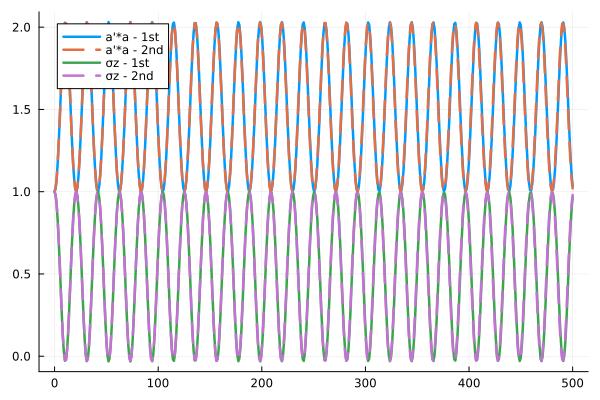

In [71]:
plot(t_list, abs.(sol_1[a'*a]), lw=2.5, label="a'*a - 1st")
plot!(t_list, abs.(sol_2[a'*a]), lw=2.5, ls=:dash, label="a'*a - 2nd")
plot!(t_list, real.(1 .- sol_1[σ(:e,:e)]), lw=2.5, label="σz - 1st")
plot!(t_list, real.(1 .- sol_2[σ(:e,:e)]), lw=2.5, ls=:dash, label="σz - 2nd")

#plot!(t_list, imag.(sol[a*σ(:e,:e)]), lw=2.5, label="a*σz")